In [79]:
import pandas as pd
ms_df=pd.read_csv('Microsoft_data.csv')
ms_df_dup=ms_df.copy()

In [80]:
# seperate cont. columns and categ. columns and fill the missing values

con_cols_dup=[col for col in ms_df_dup.columns if ms_df_dup[col].dtype=='int64' or ms_df_dup[col].dtype=='float64']
cat_cols_dup=[col for col in ms_df_dup.columns if ms_df_dup[col].dtype=='object']

for col in con_cols_dup:
    ms_df_dup[col].fillna(ms_df_dup[col].mean(),inplace=True)
for col in cat_cols_dup:
    ms_df_dup[col].fillna(ms_df_dup[col].mode()[0],inplace=True)

#ms_df_dup

In [81]:
#Anova logic - Take all cont. vriables and check correlation with output variable - HasDetections

from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')

catg=ms_df_dup['HasDetections'].value_counts().index.tolist()

catg

def anova(col):
    res=f_oneway(*[ms_df_dup[ms_df_dup['HasDetections']==cat][col]for cat in catg])
    return res[1],col

cont_data=[anova(col) for col in con_cols_dup]
#cont_data

In [82]:
# take all correlated continous variables based on P-value < 0.05

cont_col_df=pd.DataFrame(cont_data,columns=['p-value-an','col-name-an'])
cont_col_df

cont_corr_col=cont_col_df[cont_col_df['p-value-an']<0.05]
cont_corr_col_names=list(cont_corr_col['col-name-an'])
#cont_corr_col_names

In [83]:
#Logic for Chi-squared test - Take all categ. variables and find the correlation with output variable - 'HasDetections'

from scipy.stats import chi2_contingency

def chisqr(catgr):
    contingency_table=pd.crosstab(ms_df_dup[catgr],ms_df_dup['HasDetections'])
    res2=chi2_contingency(contingency_table)
    return res2[1],catgr
    

catg_data=[chisqr(catgr) for catgr in cat_cols_dup]
#catg_data

In [84]:
#Take all correlated categorical variables based on P-value - 0.05

catg_col_df=pd.DataFrame(catg_data,columns=['p-value-ch','col-name-ch'])
catg_corr_cols=catg_col_df[catg_col_df['p-value-ch']<0.05]
catg_corr_col_names=list(catg_corr_cols['col-name-ch'])
#catg_corr_col_names

In [85]:
#Merge both Cont. categ. variable in 1 list

cont_catg_corr_cols=cont_corr_col_names+catg_corr_col_names
#cont_catg_corr_cols

In [86]:
#Drop columns which are not exist in correlated fields list - We should have only correlated list
ms_df.drop(columns=[col for col in ms_df.columns if col not in cont_catg_corr_cols],inplace=True)

In [87]:
# check null values in final list (Only having correlated columns)

nainfo_df=pd.DataFrame({'col-name':ms_df.columns,
            'na-count':ms_df.isnull().sum(),
            'na-pc':ms_df.isnull().sum()/ms_df.shape[0]*100
           })




In [88]:
# Find columns which are having > 50% of null values

cols_grt_50has=list(nainfo_df[nainfo_df['na-pc']>50]['col-name'])
cols_grt_50has

['Census_ProcessorClass', 'Census_InternalBatteryType']

In [89]:
# Drop columns which are having > 50% of null values

ms_df.drop(columns=cols_grt_50has,inplace=True)

In [90]:
#Seperate Output columns from Data Frame

y=ms_df['HasDetections']
ms_df.drop(columns='HasDetections',inplace=True)


In [91]:
#Train Test Split

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(ms_df,y,random_state=44,test_size=0.25)

In [92]:
# Get continous/Categorical variables from Data Frame

con_cols_main=[col for col in ms_df.columns if ms_df[col].dtype=='int64' or ms_df[col].dtype=='float64']
cat_cols_main=[col for col in ms_df.columns if ms_df[col].dtype=='object']


In [93]:
# fill missing values in X_train, X_test

for col in con_cols_main:
    x_train[col].fillna(x_train[col].mean(),inplace=True)
    x_test[col].fillna(x_train[col].mean(),inplace=True)
    
for col in cat_cols_main:
    x_train[col].fillna(x_train[col].mode()[0],inplace=True)
    x_test[col].fillna(x_train[col].mode()[0],inplace=True)


In [94]:
#Scale continous variables

from sklearn.preprocessing import StandardScaler
import numpy as np

scaler=StandardScaler()

for col in con_cols_main:
    x_train[col]=scaler.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col]=scaler.transform(np.array(x_test[col]).reshape(-1,1))

In [95]:
# Encode categorical variable

oe_train=pd.get_dummies(x_train[cat_cols_main])
oe_test=pd.get_dummies(x_test[cat_cols_main])

oe_train_final,oe_test_final=oe_train.align(oe_test,join='inner',axis=1)

x_train_final=pd.concat([x_train[con_cols_main],oe_train_final],axis=1)
x_test_final=pd.concat([x_test[con_cols_main],oe_test_final],axis=1)

In [96]:
# Build Logistic regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score

logreg=LogisticRegression()
logreg.fit(x_train_final,y_train)
y_test_pred=logreg.predict(x_test_final)
y_test_pred

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [97]:
# Confusion matrix
confusion_matrix(y_test,y_test_pred)

array([[4434, 2563],
       [2881, 4311]], dtype=int64)

In [98]:
# Precision Score
precision_score(y_test,y_test_pred)

0.6271457666569683

In [99]:
#Recall score
recall_score(y_test,y_test_pred)

0.5994160177975528

In [100]:
#F1 score
f1_score(y_test,y_test_pred)

0.6129674392151288

Text(0.5, 1.0, 'AUC curve')

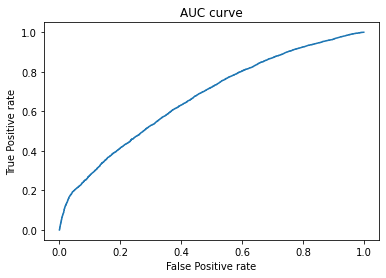

In [101]:
pos_proba=logreg.predict_proba(x_test_final)[::,1]
pos_proba
fpr,tpr,threshold=roc_curve(y_test,pos_proba)

import matplotlib.pyplot as plt
plt.plot(fpr,tpr)
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('AUC curve')

In [102]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier
dcstree=DecisionTreeClassifier()
dcstree.fit(x_train_final,y_train)
dcstree_pred=dcstree.predict(x_test_final)
dcstree_pred
confusion_matrix(y_test,dcstree_pred)

array([[3960, 3037],
       [3125, 4067]], dtype=int64)